In [3]:
from IPython.display import display, Image
display(Image(filename="notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression#学习模型
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [5]:


# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [5]:
print(train_folders,'\n',test_folders)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J'] 
 ['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


# Problem1 Display a sample 

In [6]:
nums_image_show=2
num_class=10

for index_class in range(num_class):
    image_list=os.listdir(train_folders[index_class])
    image_list_indice=image_list[0:nums_image_show]
    for index_image in image_list_indice:
        path= train_folders[index_class]+'/'+ index_image
        display(Image(path))

# 将图像数据加载成3D数组

In [7]:
image_size=28
pixel_depth=255.0

def load_letter(folder,min_num_images):
    image_files=os.listdir(folder)
    dataset=np.ndarry(shape=(len(image_files),image_size,image_size),
                        dtype=np.float32)
    print(folder)#这里有一个打印-------------
    num_images=0
    for image in image_files:
        image_file=os.path.join(folder,image)
        try:
            image_data=(ndimage.imread(image_file).astype(float)-
                       pixel_depth/2)/pixel_depth
            if image_data.shape !=(image_size,image_size):
                raise Exception("Unexpected image shape:%s"
                                % str(image_data.shape))
            dataset[num_images,:,:]=image_data
            num_images=num_images+1
        except IOError as e:
            print("Could not read:",image_file,":",e,"-it\'s ok, skipping.")

    dataset=dataset[0:num_images,:,:]
    if num_images<min_num_images:
        raise Exception('Many fewer images than expected:%d < %d'
                       %(num_images,min_num_images))
    print('Full dataset tensor:',dataset.shape)
    print('Mean:',np.mean(dataset))
    print ("Standard deviation:",np.std(dataset))
    return dataset

def maybe_pickle(data_folders,min_num_images_per_class,force=False):
    dataset_names=[]
    for folder in data_folders:
        set_filename=folder+'.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.'%set_filename)
        else:
            print('Pickling %s,'%set_filename)
            dataset=load_letter(folder,min_num_images_per_class)
            try:
                with open(set_filename,'wb') as f:
                    pickle.dump(dataset,f,pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to asve data to',set_filename,':',e)
    return dataset_names
train_datasets=maybe_pickle(train_folders,45000)
test_datasets=maybe_pickle(test_folders,1800)
    

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

In [8]:
train_datasets

['notMNIST_large/A.pickle',
 'notMNIST_large/B.pickle',
 'notMNIST_large/C.pickle',
 'notMNIST_large/D.pickle',
 'notMNIST_large/E.pickle',
 'notMNIST_large/F.pickle',
 'notMNIST_large/G.pickle',
 'notMNIST_large/H.pickle',
 'notMNIST_large/I.pickle',
 'notMNIST_large/J.pickle']

# Problem 2 从pickle二进制文件中读取图片

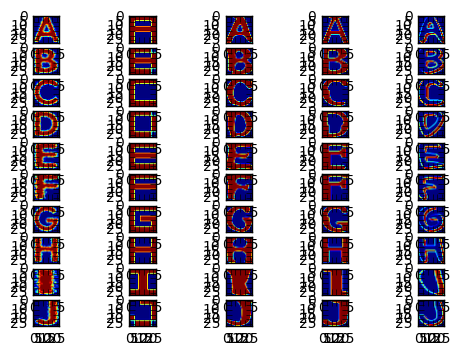

In [9]:
#Problem2 Displaying a sample of the labels and images from the ndarray

# Config the matplotlib backend as plotting inline in IPython

import matplotlib.pyplot as plt
def load_and_displayImage_from_pickle(data_filename_set,numClass,NumImage):
    if(NumImage<=0):
        print("NumImage<=0")
        return
    plt.figure('subplot')
    for index,pickle_file in enumerate(data_filename_set):
        with open(pickle_file,'rb') as f:
            data=pickle.load(f)
            ImageList=data[0:NumImage,:,:]
            for i,Image in enumerate (ImageList):
                plt.subplot(numClass,NumImage,index*NumImage+i+1)
                plt.imshow(Image)
#             index=index+1

load_and_displayImage_from_pickle(train_datasets,10,5)
load_and_displayImage_from_pickle(test_datasets,10,5)
        

In [10]:
for index,pickle_file in enumerate(train_datasets):
    print("index is:",index,",dataset is-",pickle_file)

index is: 0 ,dataset is- notMNIST_large/A.pickle
index is: 1 ,dataset is- notMNIST_large/B.pickle
index is: 2 ,dataset is- notMNIST_large/C.pickle
index is: 3 ,dataset is- notMNIST_large/D.pickle
index is: 4 ,dataset is- notMNIST_large/E.pickle
index is: 5 ,dataset is- notMNIST_large/F.pickle
index is: 6 ,dataset is- notMNIST_large/G.pickle
index is: 7 ,dataset is- notMNIST_large/H.pickle
index is: 8 ,dataset is- notMNIST_large/I.pickle
index is: 9 ,dataset is- notMNIST_large/J.pickle


# Problem3 验证数据样本大小是否相当

train_datasets:

52909
52911
52912
52911
52912
52912
52912
52912
52912
52911


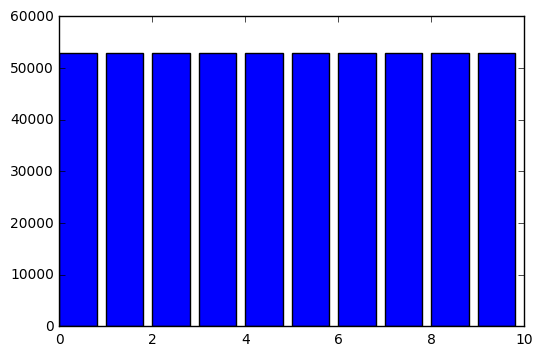

test_datasets:

1872
1873
1873
1873
1873
1872
1872
1872
1872
1872


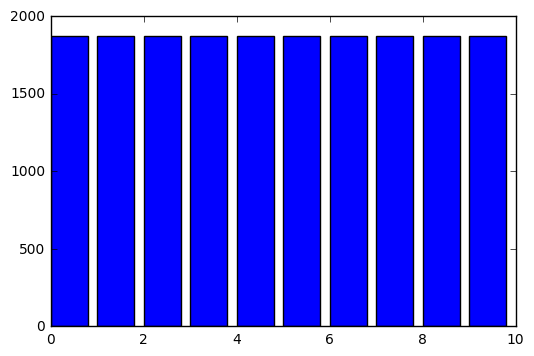

In [11]:
def show_sum_of_diffrent_class(data_filename_set):
    sumofdifferentclass=[]
    for pickle_file in data_filename_set:
        with open(pickle_file,'rb') as f:
            data=pickle.load(f)
            print(len(data))
            sumofdifferentclass.append(len(data))
    x=np.arange(10)
    plt.figure(1)
    plt.bar(x,sumofdifferentclass)
   # plt.axis('off')
    plt.show()
    
print('train_datasets:\n')
show_sum_of_diffrent_class(train_datasets)
print('test_datasets:\n')
show_sum_of_diffrent_class(test_datasets)

In [12]:
#辅助函数的作用是返回一个给定大小nb_roes的两个ndarray空数组
#如果nb_rows=0那么返回的None就是空数组
def make_arrays(nb_rows,img_size):
    if nb_rows:
        dataset=np.ndarray((nb_rows,img_size,img_size),dtype=np.float32)
        labels=np.ndarray(nb_rows,dtype=np.int32)
    else:
        dataset,labels=None,None
    return dataset,labels

def merge_dataset(pickle_files,train_size,valid_size=0):
    num_classes=len(pickle_files)
    valid_dataset,valid_labels=make_arrays(valid_size,image_size)
    train_dataset,train_labels=make_arrays(train_size,image_size)
    vsize_per_class=valid_size//num_classes
    tsize_per_class=train_size//num_classes
    
    start_v,start_t=0,0
    end_v,end_t=vsize_per_class,tsize_per_class
    endl=vsize_per_class+tsize_per_class
    for label,pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file,'rb') as f:
                letter_set=pickle.load(f)
                #shuffle the letter
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter=letter_set[:vsize_per_class,:,:]
                    valid_dataset[start_v:end_v,:,:]=valid_letter
                    valid_labels[start_v:end_v]=label
                    start_v+=vsize_per_class
                    end_v+=vsize_per_class

                train_letter=letter_set[vsize_per_class:endl,:,:]
                train_dataset[start_t:end_t,:,:]=train_letter
                train_labels[start_t:end_t]=label
                start_t+=tsize_per_class
                end_t+=tsize_per_class
        except Exception as e:
            print('Unable to process data from ',pickle_file,':',e)
#             raise

    return valid_dataset,valid_labels,train_dataset,train_labels

train_size=200000
valid_size=10000
test_size=10000

valid_dataset,valid_labels,train_dataset,train_labels=merge_dataset\
(train_datasets,train_size,valid_size)

_,_,test_dataset,test_labels=merge_dataset(test_datasets,test_size)

print('Training:',train_dataset.shape,train_labels.shape)
print('Validation:',valid_dataset.shape,valid_labels.shape)
print('Training:',test_dataset.shape,test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Training: (10000, 28, 28) (10000,)


In [13]:
#现在的训练数据全是按类别排列的，要打乱训练数据
def randomize(dataset,labels):
    permutation=np.random.permutation(labels.shape[0])
#因为要做到dataset和labels打乱顺序一致所以不能random.shuffle
    shuffled_dataset=dataset[permutation,:,:]
    shuffled_labels=labels[permutation]
    return shuffled_dataset,shuffled_labels

train_dataset,train_labels=randomize(train_dataset,train_labels)
valid_dataset,valid_labels=randomize(valid_dataset,valid_labels)
test_dataset,test_labels=randomize(test_dataset,test_labels)

# Problem4 验证shuffle后的数据仍然有效

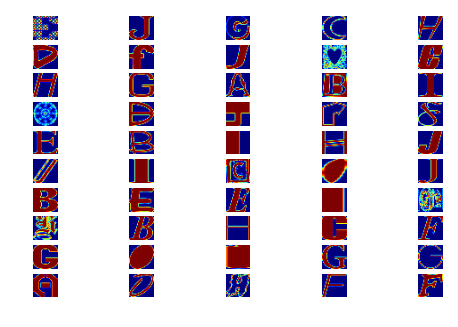

In [15]:
#data_set是数据集，NumImage是显示的图像张数
def displayImage_from_dataset(data_set,NumImage):
    if(NumImage<=0):
        print("NumImage<=0")
        return
    plt.figure('subplot')
    ImageList=data_set[0:NumImage,:,:]
    for index,Image in enumerate(ImageList):
        plt.subplot(NumImage//5+1,5,index+1)
        plt.axis('off')
        plt.imshow(Image)
    plt.show()
    
displayImage_from_dataset(train_dataset,50)

In [16]:
#save data for reuse
pickle_file='notMNIST.pickle'

try:
    f=open(pickle_file,'wb')
    save={
        'train_dataset':train_dataset,
        'train_labels':train_labels,
        'valid_dataset':valid_dataset,
        'valid_labels':valid_labels,
        'test_dataset':test_dataset,
        'test_labels':test_labels,
    }
    pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
    print('Success write data to %s' %pickle_file)
    f.close()
except Exception as e:
    print('Unable to save data to',pickle_file,':',e)

Success write data to notMNIST.pickle


In [17]:
#压缩文件
statinfo =os.stat(pickle_file)
print("Compressed pickle size:",statinfo.st_size)

Compressed pickle size: 690800512


# Problem5 数据清洗

Number of overlaps: 1324


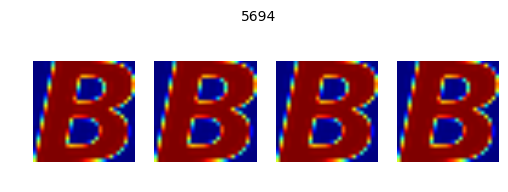

Overlapping images removed from test_dataset:  1324
Overlapping images removed from valid_dataset:  1067
Training: (200000, 28, 28) (200000,)
Validation: (8933, 28, 28) (8933,)
Testing: (8676, 28, 28) (8676,)


In [18]:
import hashlib

#sha的作用是将二维数组映射为hash字符串
#ndarray数据无法用set来取交集
def extract_overlap_hash_where(dataset_1,dataset_2):
    dataset_hash_1=np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2=np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap={}
    for i,hash1 in enumerate(dataset_hash_1):
        duplicates=np.where(dataset_hash_2==hash1)
        if len(duplicates[0]):
            overlap[i]=duplicates[0]#dul[0]是一个array
    return overlap#overlap是dic
#overlap的key是test的索引，val是trainset的索引

#display overlap part
def display_overlap(overlap,source_dataset,target_dataset):
    overlap={k:v for k,v in overlap.items() if len(v)>=3}#选取重复大于3次的元素
    item=np.random.choice(list(overlap.keys()))
    imgs=np.concatenate(([source_dataset[item]],target_dataset[overlap[item][0:7]]))
    plt.suptitle(item)
    for i,img in enumerate(imgs):
        plt.subplot(2,4,i+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()
        
# 数据清洗
def sanitize(dataset_1,dataset_2,labels_1):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = []
    for i,hash1 in enumerate(dataset_hash_1):
        duplicates=np.where(dataset_hash_2==hash1)
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset_1,overlap,0),np.delete(labels_1,overlap,0)
    

overlap_test_train = extract_overlap_hash_where(test_dataset,train_dataset)
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset, train_dataset)
#训练集中有重复就算了。。。这里是这个思想  只要valid和test中没有就行。。。
test_dataset_sanit,test_labels_sanit = sanitize(test_dataset,train_dataset,test_labels)
print('Overlapping images removed from test_dataset: ', len(test_dataset) - len(test_dataset_sanit))

valid_dataset_sanit, valid_labels_sanit = sanitize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed from valid_dataset: ', len(valid_dataset) - len(valid_dataset_sanit))


print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset_sanit.shape, valid_labels_sanit.shape)
print('Testing:', test_dataset_sanit.shape, test_labels_sanit.shape)

In [22]:
#将清洗后的数据存储到notMNIST_sanit.pickle并进行压缩，和上面差不多
pickle_file_sanit = 'notMNIST_sanit.pickle'
try:
    f = open(pickle_file_sanit,'wb')
    save = {
        'train_dataset':train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset_sanit,
        'valid_labels': valid_labels_sanit,
        'test_dataset': test_dataset_sanit,
        'test_labels': test_labels_sanit,
    }
    pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo_sanit = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo_sanit.st_size)
#从下面单元格代码可以看出，清洗后的数据集确实是小了一些

Compressed pickle size: 683292772


In [23]:
#这个是没有清洗过的数据集
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


In [3]:
def train_and_predict(sample_size):
    regr=LogisticRegression()
    X_train=train_dataset[:sample_size].reshape(sample_size,784)
    Y_train=train_labels[:sample_size]
    regr.fit(X_train,Y_train)
    
    X_test=test_dataset.reshape(test_dataset.shape[0],784)
    Y_test=test_labels
    pre_labels=regr.predict(X_test)
    print('Accurancy',regr.score(X_test,Y_test),'when sample_size=',sample_size) 
    
for sample_size in [50,100,1000,5000,10000]:
    train_and_predict(sample_size)

NameError: name 'train_dataset' is not defined

In [28]:
def train_and_predict(sample_size):
    regr=LogisticRegression()
    X_train=train_dataset[:sample_size].reshape(sample_size,784)
    Y_train=train_labels[:sample_size]
    regr.fit(X_train,Y_train)
    
    X_test=test_dataset_sanit.reshape(test_dataset_sanit.shape[0],784)
    Y_test=test_labels_sanit
    pre_labels=regr.predict(X_test)
    print('Accurancy',regr.score(X_test,Y_test),'when sample_size=',sample_size) 
    
for sample_size in [50,100,1000,5000,10000]:
    train_and_predict(sample_size)
#由以下结果可以看出经过净化sanitize后的数据集的确准确率会下降

Accurancy 0.496196403873 when sample_size= 50
Accurancy 0.683033656063 when sample_size= 100
Accurancy 0.820193637621 when sample_size= 1000
Accurancy 0.838635315814 when sample_size= 5000
Accurancy 0.847395112955 when sample_size= 10000
